# The Embedding Notebook 3
## John E. Inglesfield
This is the third embedding notebook, providing short computer programs to illustrate the embedding method, and to accompany my book *The Embedding Method for Electronic Structure* (ebook ISBN 978-0-7503-1042-0, print ISBN 978-0-7503-1043-7), published in the *Expanding Physics* ebook program by [IOP Publishing](http://iopscience.iop.org/books/iop-expanding-physics). As with the earlier notebooks, this can be used independently of the book, but the references are to chapters, figures, and equations. Atomic units are used throughout, with $e=\hbar=m_e=1$.

This notebook uses the `Numpy`, `Matplotlib`, and `Cmath` modules, as well as the `transport.py` module in the repository, which itself uses `Numpy`, `Scipy`, and `Cmath`. First of all we load the required modules:

In [1]:
import numpy as np
from numpy import pi, sqrt
import matplotlib.pyplot as plt
import cmath
import transport as trans
%matplotlib inline

## Chapter 7 The embedding potential and electron transport
In this notebook we show how the embedding potential $\Sigma$ enters electron transport, illustrating this with transport through the circular corner waveguide joined on to infinitely long straight sections (Notebook 2), shown below:
<img src=circular_corner.png width=400 height=400 />
As in Notebook 2, here we solve the Schrödinger equation explicitly in region I as shown in the figure, adding a confining embedding potential (chapter 5) over the red lines, and embedding potentials over the blue lines to replace the straight sections of waveguide. The basis functions, defined with respect to the coordinate origin at the corner of the green-dashed square, are given by
$$\chi_{pq}(x,y)=\cos(p\pi x/D)\cos(q\pi y/D),\quad p,q=0,1,2\ldots,$$
with $D>r_2$ to achieve flexibility of boundary condtiions over the limits of region I.  
The starting point for all the calculations in this notebook is the Green function for this system $G(\mathbf{r},\mathbf{r}';E)$, satisfying the embedded Schrödinger equation in region I. To remind ourselves of the properties of the Green function, we shall repeat the calculation of the local density of states of the corner (Notebook 2, and section 5.5.2 in the book), given by
$$n_\mathrm{I}(E)=-\frac{1}{\pi}\Im\int_\mathrm{I}\textrm{d}\mathbf{r}\,G(\mathbf{r},\mathbf{r};E).$$
In this calculation, we have outgoing boundary conditions on the junctions with the straight sections (the blue lines), and consequently the embedding potential at the top left-hand side of the corner has the form
$$\Sigma(\tilde{y},\tilde{y}')=-\frac{\textrm{i}}{w}\sum_p k_p\sin(p\pi\tilde{y}/w)\sin(p\pi\tilde{y}'/w),$$
with an equivalent embedding potential at the bottom right-hand side boundary. Here $\tilde{y},\tilde{y}'$ are the $y$-coordinates relative to $(x,y)=[(D-r_2)/2,(D-r_2)/2+r_1]$ (the bottom of the waveguide junction), $w$ is the width of the waveguide, and the sum is over the waveguide channels $p$. $k_p$ is the outgoing wavevector in the $p$th channel, given at energy $E$ (5.30) by
$$k_p=\sqrt{2E-p^2\pi^2/w^2}.$$
The input parameters for this and subsequent calculations in the notebook are the confining potential outside region I, $\mathcal{V}$, which of course determines the confining embedding potential along the red boundary of the curved waveguide (notebook 2 and section 5.1), the inner and outer radii of the corner, $r_1$ and $r_2$, the parameter $D$ defining the above basis functions, and the number $N$ of basis functions in each direction. Values which I have found appropriate are $\mathcal{V}=1\times 10^5$, $r_1=0.2$, $r_2=1.2$, $D=1.5$, and $N=8$: 

In [2]:
# Confining potential, inner and outer radii, basis function parameter, and number of basis
# functions in each direction.
V, r1, r2, D, N = 1.0e5, 0.2, 1.2, 1.5, 8
w = r2 - r1

These values can of course be changed to explore the behaviour of the method and results, but remember that the total number of basis functions is $N^2$. We also need the number of embedding channels $p$, which here we input as `n_emb`. A value of 10 is more than enough.

In [3]:
n_emb = 10 # number of embedding channels

The first part of the calculations, and the really time-consuming stage, is to evaluate once and for all the matrix elements, that is, the Hamiltonian and overlap integrals (equation 5.8). In the following, the Hamiltonian (including the confinement embedding matrix elements) is contained in the `numpy` array `ham`, the overlap in `ovlp`, and `al`, `be` are arrays which defines the matrix elements. `in_ovlp` and `out_ovlp` are used to find the matrix elements of the embedding potentials at the junctions with the straight sections. As in notebook 2, the program outputs (encouraging!) information about the rate of evaluation of the integrals.

In [4]:
param = V, r1, r2, D, N
ham, ovlp, al, be = trans.corner_matrices(param)
in_ovlp, out_ovlp = trans.corner_embed_matrices(n_emb, al, be)

Number of integrals done =   5 x  64
Number of integrals done =  10 x  64
Number of integrals done =  15 x  64
Number of integrals done =  20 x  64
Number of integrals done =  25 x  64
Number of integrals done =  30 x  64
Number of integrals done =  35 x  64
Number of integrals done =  40 x  64
Number of integrals done =  45 x  64
Number of integrals done =  50 x  64
Number of integrals done =  55 x  64
Number of integrals done =  60 x  64
Number of integrals done =  64 x  64


We now calculate the (outgoing) Green function for the circular corner, embedded on to the straight sections of waveguide. This is central to *all* the calculations in transport, as we see from chapter 7. Note that in this transport notebook, we work at *real* energies, so this density of states calculation does not pick up the bound state below the first energy threshold. This is because the bound state (unlike resonances) plays no part in transport (section 7.1.2).  
In the following cell, after inputting the start and end of the energy range, `en_start`, `en_end`, and the number of energy points, `number_en`, we calculate the corner density of states, given in terms of the Hamiltonian, embedding, and overlap matrices by (2.43)
$$n_\mathrm{I}(E)=-\frac{1}{\pi}\Im\;\mathrm{tr}\,[(EO-\Sigma-H)^{-1}O].$$
$n_\mathrm{I}$ is contained in the list `dos`, evaluated at the energies contained in `elist`.

In [5]:
en_start, en_end, number_en = 4.5, 30.0, 500 # start energy, finish energy, no. of energies
elist=np.linspace(en_start, en_end, number_en)
dos=[]
for E in elist:
    green=trans.corner_green(E, ham, ovlp, n_emb, in_ovlp, out_ovlp)
    dos.append(-np.trace(np.dot(green, ovlp)).imag/pi)

The density of states is finally plotted; the parameter `dos_range` determines the range of the plot, and can be varied. 

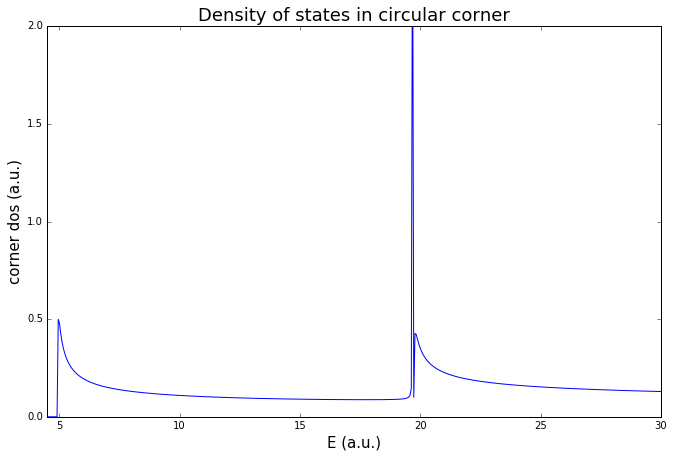

In [6]:
dos_range = 2.0 # range of density of states plotted
plt.figure(figsize = (11, 7))
plt.xlabel('E (a.u.)', fontsize = 15)
plt.ylabel('corner dos (a.u.)', fontsize = 15)
plt.title('Density of states in circular corner', fontsize = 18)
plt.axis([en_start, en_end, 0.0, dos_range])
plt.plot(elist, dos)

We note that the density of states at real energies shows the resonances, which, unlike localised bound states, do play a role in transport. These resonances arise from a bound state associated with a threshold leaking into the overlapping continuum. 

### Continuum wave-functions and current density
We now come on to electron transport through the circular corner, using the density of states shown above as a guide to interesting features. In terms of the embedding potential, we can find the wave-function in region I, here the circular corner, given a wave incident on the corner from, say, the top-left straight waveguide. Starting off from Dyson's equation, and making use of Green's theorem and the properties of the embedding potential, we can show that the wave-function in region I is given by (equation 7.21),
$$\Psi(\mathbf{r})=-2\mathrm{i}\int_{S_\mathbf{L}}\mathrm{d}\mathbf{r}_S \int_{S_\mathbf{L}}\mathrm{d}\mathbf{r}'_S G(\mathbf{r},\mathbf{r}_S) \Im\Sigma_\mathbf{L}(\mathbf{r}_S,\mathbf{r}'_S)\psi(\mathbf{r}'_S),$$
where the double integral is over the top-left boundary surface $S_\mathbf{L}$ through which the incoming wave $\psi$ enters the corner. $\Im\Sigma_\mathbf{L}$ is the imaginary part of the embedding potential on this surface, and $G$ is the fully embedded Green function for the corner.  
It is natural to take $\psi$ in the form of a *channel function* (section 7.1.1), given by
$$\psi_p(\mathbf{r})=\sin(p\pi\tilde{y}/w)\exp(\mathrm{i}k_p\tilde{x}),$$
where $\tilde{x}$ and $\tilde{y}$ are measured from the bottom of the waveguide junction
(see above in the expression for the embedding potential). The wave-vector of propagation in the $p$'th mode $k_p$ is given by the expression in the embedding potential formula. The expression for $\Psi$ then simplifies to
$$\Psi(\mathbf{r})=\mathrm{i}k_p\int_0^w\mathrm{d}\tilde{y}\;G[\mathbf{r},(\tilde{x}=0,\tilde{y})]\sin(p\pi\tilde{y}/w).$$
The current density can immediately be found from $\Psi$, $\mathbf{J}=\Im\,\Psi^*\nabla\Psi$. Note that the incoming current (current density $\times$ area) is $wk_p/2$ (unlike in chapter 7 the channel function is not normalized).  
First we must feed in the energy $E$ and channel $p$ of the incoming wave, remembering that
$$E>\frac{p^2\pi^2}{2w^2}.$$
In the following, the convention is that the lowest input channel has the parameter `input_channel = 0`, in other words  
`p = input_channel + 1`.

In [7]:
input_channel =  int(raw_input('Input channel? '))
E_channel = 0.5 * ((input_channel+1)*pi/w)**2
print '%s %.3f' % ('Channel energy = ', E_channel)
E = float(raw_input('Energy (> channel energy)? '))

Input channel? 0
Channel energy =  4.935
Energy (> channel energy)? 19.7


We now calculate the Green function, hence the wave-function; in the following, `psi` is an array containing the expansion coefficients of $\Psi(\mathbf{r})$.

In [8]:
kz = sqrt(2.0 * (E-E_channel))
sigma = -1j * kz/w
psi_input = 0.5* w * in_ovlp[input_channel,:]
green = trans.corner_green(E, ham, ovlp, n_emb, in_ovlp, out_ovlp)
psi = -2.0*1j * sigma.imag*np.dot(green, psi_input)

This is used to evaluate $\Psi(\mathbf{r})$ and $\mathbf{J}(\mathbf{r})$ on a grid for plotting. The parameter `n_plot` determines the number of plotting points in each direction, and of course you can vary this as you wish.

In [9]:
n_plot = 30 # number of plotting points in each direction. You can vary this as you wish.
xy_values = np.linspace(0.0, r2, n_plot)
X, Y = np.meshgrid(xy_values, xy_values)
jx = np.zeros((n_plot, n_plot)) # x-component of current density
jy = np.zeros((n_plot, n_plot)) # y-component of current density
Psi = np.zeros((n_plot, n_plot), complex) # Complex wave-function
for k in range(n_plot):
    for l in range(n_plot):
        xp = X[k,l]
        yp = Y[k,l]
        Psi[k, l], jx[k, l],jy[k, l] = trans.corner_current(psi, xp, yp, al, be)

First we plot the complex wave-function, which we do in two ways: real and imaginary parts, and modulus and phase. Unlike in the previous notebooks, here we only plot $\Psi$ inside the waveguide, setting it to zero outside.

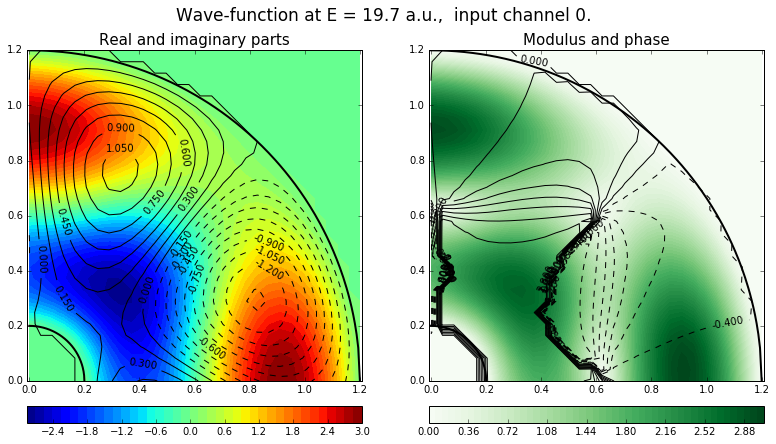

In [11]:
Z_mod = np.zeros((n_plot, n_plot))
Z_phase = np.zeros((n_plot, n_plot))
for k in range(n_plot):
    for l in range(n_plot):
        Z_mod[k, l], Z_phase[k, l] = cmath.polar(Psi[k, l])
plt.figure(figsize=(13.2, 7.5))
plt.subplot(1, 2, 1)
plt.contourf(X, Y, Psi.real, 50)
plt.colorbar(orientation='horizontal', pad=0.06)
cs = plt.contour(X, Y, Psi.imag, 20, colors='black')
plt.clabel(cs, color='black')
x_values = np.linspace(0.0, r2, 200)
plt.plot(x_values, sqrt(r2*r2 - x_values*x_values), linewidth=2.0, color='black')
x_values = np.linspace(0.0, r1, 200)
plt.plot(x_values, sqrt(r1*r1 - x_values*x_values), linewidth=2.0, color='black')
plt.title('Real and imaginary parts', fontsize=15)
plt.axis('equal')
plt.subplot(1, 2, 2)
plt.contourf(X, Y, Z_mod, 50, cmap='Greens')
plt.colorbar(orientation='horizontal', pad=0.06)
cs = plt.contour(X, Y, Z_phase, 20, colors='black')
plt.clabel(cs, color='black')
x_values = np.linspace(0.0, r2, 200)
plt.plot(x_values, sqrt(r2*r2 - x_values*x_values), linewidth=2.0, color='black')
x_values = np.linspace(0.0, r1, 200)
plt.plot(x_values, sqrt(r1*r1 - x_values*x_values), linewidth=2.0, color='black')
plt.title('Modulus and phase', fontsize=15)
plt.axis('equal')
plt.suptitle('Wave-function at E = ' + str(E) + ' a.u.,'
             + '  input channel '+str(input_channel) + '.',fontsize=17)

In the left-hand figure $\Re\Psi$ is plotted on the colour scale, and $\Im\Psi$ indicated by the black contour lines. In the right-hand figure $|\Psi|$ is indicated on the green-density scale, and $\mathrm{arg}\,\Psi$ by the contours .

At low energies it is interesting to see how the wave-function bends smoothly round through the waveguide. Note that it is only in such cases, when there is little reflection back into the entrance waveguide, that the wave-function at the junction matches on to the *incident* channel function (of course it must always match on to the incident + reflected wave). 

Finally we plot the vector field of the current density in the waveguide, using the `quiver` option of `Matplotlib`.

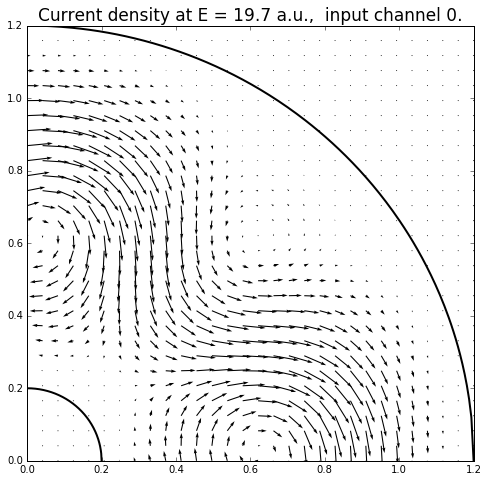

In [12]:
plt.figure(figsize=(8, 7.8))
plt.quiver(X, Y, jx, jy)
plt.axis([0.0, r2,0.0, r2], 'equal')
x_values = np.linspace(0.0, r2, 200)
plt.plot(x_values, sqrt(r2*r2 - x_values*x_values), linewidth=2.0, color='black')
x_values=np.linspace(0.0, r1, 200)
plt.plot(x_values, sqrt(r1*r1 - x_values*x_values), linewidth=2.0, color='black')
plt.title('Current density at E = ' + str(E) + ' a.u.,'
             + '  input channel '+str(input_channel) + '.',fontsize=17)

What is really interesting is to study the current at an energy corresponding to a resonance peak in the density of states, for example at $E\approx 19.7$ a.u. with $r_1=0.2$, $r_2=1.2$ a.u. Instead of a smooth flow of current through the corner we see vortices. This can be compared with the results shown in figure 7 of [Dix and Inglesfield](http://iopscience.iop.org/0953-8984/10/26/018) (E. Dix and J.E. Inglesfield, J. Phys. Condens. Matter **10** 5923-5941 (1998)). (How much clearer things look nowadays with better plotting!)

### Partial transmission probabilities
We define the partial transmission probability $T_{pq}$ as the probability for transmission into open exit channel $q$ from input channel $p$, in other words the current transmitted into channel $q$ for unit current in channel $p$ (section 5.4.2). We can calculate the amplitude of the transmitted wave $t_{pq}$ by projecting $\Psi(\mathbf{r})$ on to the exit channel wave-function, but we must remember to include the wave-vector factor $k_q/k_p$ to obtain the corresponding transmission probability (equation 5.23),
$$T_{pq}=|t_{pq}|^2\frac{k_q}{k_p}.$$
To calculate $T_{pq}(E)$ we input the range of energies, and then the program asks you for the input channel $p$. The number of open exit channels, `q_range` in the code, is calculated from the range of energies. (Remember, however, that the Green function in the corner is calculated with an embedding potential including `n_emb` channels - open *and* closed channels contribute to the embedding potential.)

Input channel? 0


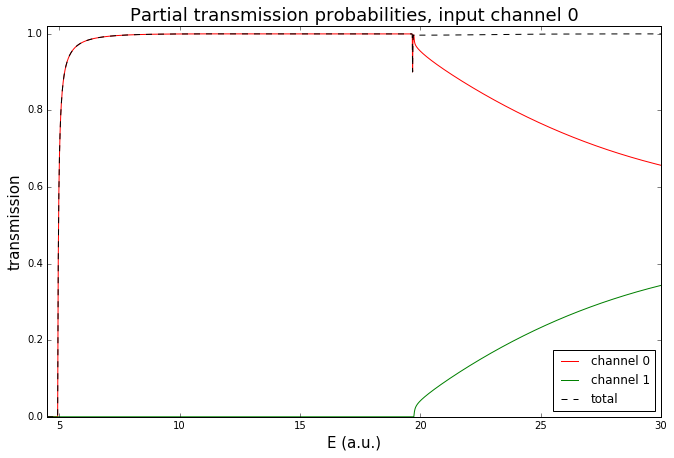

In [13]:
en_start, en_end, number_en = 4.5, 30.0, 2000 # start energy, finish energy, no. of energies
input_channel = int(raw_input('Input channel? '))
q_range = 1
while en_end > 0.5 * ((q_range+1)*pi/w)**2:
    q_range += 1
elist = np.linspace(en_start, en_end, number_en)
transmit = np.array([[trans.corner_transmission(E, ham, ovlp, n_emb,
                      in_ovlp, out_ovlp, input_channel, output_channel)
                      for output_channel in range(q_range)] for E in elist])
total = np.sum(transmit, axis=1)
colour = ['red', 'green', 'blue', 'cyan', 'magenta']
plt.figure(figsize = (11, 7))
plt.xlabel('E (a.u.)', fontsize = 15)
plt.ylabel('transmission', fontsize = 15)
plt.title('Partial transmission probabilities, input channel '+str(input_channel), 
          fontsize = 18)
plt.axis([en_start, en_end, 0.0, 1.02])
for q in range(q_range):
    plt.plot(elist, transmit[:,q], color=colour[q], label='channel ' + str(q))
plt.plot(elist, total, color='black', linestyle='dashed', label='total')
plt.legend(loc='best', fontsize=12)

In this plot, the partial probabilities into the different exit channels are plotted in different colours; the total transmission probability from input channel $p$, defined as
$$T_p=\sideset{}{'}\sum_q T_{pq},$$
is shown by the dashed black curve (equation 5.25). (The prime indicates that the sum is over open exit channels.)  
The results show that for the circular corner, the transmission is very close to unity, above the theshold for the particular input channel. When a new output channel opens up, the total transmission *stays* close to unity, even though some of the output current is transferred to the new channel. However, at an energy close to a resonance peak in the density of states, the transmission drops very sharply. (This is discussed in [Dix and Inglesfield](http://iopscience.iop.org/0953-8984/10/26/018) (E. Dix and J.E. Inglesfield, J. Phys. Condens. Matter **10** 5923-5941 (1998)).) It is interesting to explore the behaviour with different input channels and ranges of energies. 

### Total transmission
To calculate the conductance of a system like the waveguide corner we need the total transmission probability at energy $E$ of all open entrance channels $p$ into all open exit channels $q$,
$$T(E)=\sideset{}{'}\sum_{pq} T_{pq}(E).$$
As discussed in section 7.1.3 (equation 7.32), this can be written as a *single* formula,
$$T=4\,\mathrm{tr}\,[G_\mathrm{RL}\,\Im\Sigma_\mathrm{L}\,G^*_\mathrm{LR}\,\Im\Sigma_\mathrm{R}],$$
where the subscript $\mathrm{L}$ implies the entrance to the waveguide corner (the top-left blue line in the figure) and $\mathrm{R}$ the exit (the bottom-right blue line). $G_\mathrm{RL}$ is then the embedded Green function, in a matrix representation, coupling exit and entrance, and $G_\mathrm{LR}$ the Green function coupling entrance and exit; $\Sigma_\mathrm{L}$ is the embedding potential at the entrance, and $\Sigma_\mathrm{R}$ the embedding potential at the exit. Matrix multiplication is implied in this expression, and the trace is taken over the final matrix.

This result, which is well-known in a local orbital representation (in which the embedding potential is invariably called the *self-energy*), was originally derived by 
[Meir and Wingreen](http://journals.aps.org/prl/abstract/10.1103/PhysRevLett.68.2512) (Y. Meir and N.S. Wingreen, Phys. Rev. Lett. **68** 2512-2515 (1992)). It was derived in the form used here, with real space embedding potentials, by [Wortmann *et al*](http://journals.aps.org/prb/abstract/10.1103/PhysRevB.66.075113) (D. Wortmann, H. Ishida and S. Blügel, Phys. Rev. B **66** 075113 (2002)).

We now calculate $T(E)$ using the same range of energies as above, plotting the results. 

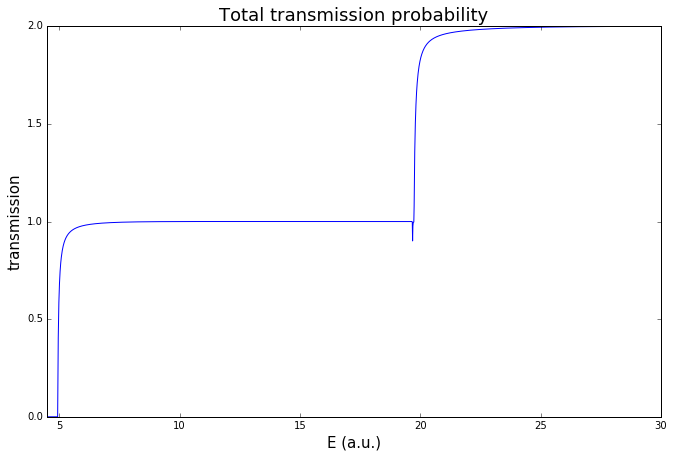

In [14]:
transmit = [] # total transmission
dos = []      # density of states (as above)
left_dos = [] # left density of states (see below)
for E in elist:
    green = trans.corner_green(E, ham, ovlp, n_emb, in_ovlp, out_ovlp)
    Sigma_in = np.zeros((N*N, N*N))
    Sigma_out = np.zeros((N*N, N*N))
    for p in range(n_emb):
        sigma = -1j*cmath.sqrt(2.0*E - ((p+1)*pi/w)**2)/w
        Sigma_in = Sigma_in + sigma.imag*np.outer(in_ovlp[p,], in_ovlp[p,])
        Sigma_out = Sigma_out + sigma.imag*np.outer(out_ovlp[p,], out_ovlp[p,])
    sig_green = np.dot(Sigma_in, np.conj(green))
    green_sig_green = np.dot(green, sig_green).real
    green_sig_green_sig = np.dot(green_sig_green, Sigma_out)
    dos.append(-np.trace(np.dot(green,ovlp)).imag/pi)
    left_dos.append(-np.trace(np.dot(green_sig_green,ovlp))/pi)
    transmit.append(4.0*np.trace(green_sig_green_sig))
plt.figure(figsize = (11, 7))
plt.xlim(xmin=en_start, xmax=en_end)
plt.xlabel('E (a.u.)', fontsize = 15)
plt.ylabel('transmission', fontsize = 15)
plt.title('Total transmission probability', fontsize = 18)
plt.plot(elist, transmit)

We can see that $T(E)=\sum_p$(our previous results): it shows step structure as new channels open up, with narrow features at the resonance energies. This is much simpler than $T(E)$ for the waveguide kink discussed in section 7.1.3 (figure 7.4), because the electrons can flow through the cicular corner in a much smoother way, except at the resonances, than in the kink.

### Left and right densities of states
In this last section we consider once again the corner density of states: as we discuss in section 7.1.2, the continuum states come either from travelling waves incident on the corner from the straight waveguide at the top-left (left states), or from waves entering the corner from the bottom-right waveguide (right states) ([D. Wortmann, H. Ishida and S. Blügel](http://journals.aps.org/prb/abstract/10.1103/PhysRevB.66.075113), Phys. Rev. B **66** 075113 (2002), see also S. Datta *Quantum Transport: Atom to Transistor* (Cambridge University Press, 2005)).

These waves can be calculated in the form given above,
$$\Psi_{\mathrm{L},p}(\mathbf{r})=-2\mathrm{i}\int_{S_\mathbf{L}}\mathrm{d}\mathbf{r}_S \int_{S_\mathbf{L}}\mathrm{d}\mathbf{r}'_S G(\mathbf{r},\mathbf{r}_S) \Im\Sigma_\mathbf{L}(\mathbf{r}_S,\mathbf{r}'_S)\psi_p(\mathbf{r}'_S),\;
\Psi_{\mathrm{R},p}(\mathbf{r})=-2\mathrm{i}\int_{S_\mathbf{R}}\mathrm{d}\mathbf{r}_S \int_{S_\mathbf{R}}\mathrm{d}\mathbf{r}'_S G(\mathbf{r},\mathbf{r}_S) \Im\Sigma_\mathbf{R}(\mathbf{r}_S,\mathbf{r}'_S)\psi_p(\mathbf{r}'_S),$$
where we have added the suffices $\mathrm{L},\mathrm{R}$ to indicate left/right states, and $p$ to indicate the input channel. The integrals in $\Psi_\mathrm{L}$ are over $S_\mathbf{L}$, the waveguide junction at the top-left, and in $\Psi_\mathrm{R}$ over $S_\mathbf{R}$, the waveguide junction at the bottom-right. The local density of states can then be written as (equation 7.26),
$$n(\mathbf{r},E)=n_\mathrm{L}(\mathbf{r},E)+n_\mathrm{R}(\mathbf{r},E),$$
where the left and right local densities of states are given by,
$$
\begin{align}
n_\mathrm{L}(\mathbf{r},E)&=\sideset{}{'}\sum_p \Psi^*_{\mathrm{L},p}(\mathbf{r})\Psi_{\mathrm{L},p}(\mathbf{r})\\
n_\mathrm{R}(\mathbf{r},E)&=\sideset{}{'}\sum_p \Psi^*_{\mathrm{R},p}(\mathbf{r})\Psi_{\mathrm{R},p}(\mathbf{r}).
\end{align}
$$
Here $\Psi_{\mathrm{L},p}$ and $\Psi_{\mathrm{R},p}$ are left and right states at energy $E$, with *energy-normalization* of the incoming states (see under equation 7.24 for more details of energy-normalization). As shown in section 7.1.2, these expressions can be simplified, giving
$$n_\mathrm{L}(\mathbf{r},E)=-\frac{1}{\pi}\int_{S_\mathbf{L}}\mathrm{d}\mathbf{r}_S \int_{S_\mathbf{L}}\!\mathrm{d}\mathbf{r}'_S \,G(\mathbf{r},\mathbf{r}_S) \Im\Sigma_\mathbf{L}(\mathbf{r}_S,\mathbf{r}'_S)G^*(\mathbf{r}'_S,\mathbf{r}),$$
with a similar expression for $n_\mathrm{R}(\mathbf{r},E)$. Integrating over region I to obtain the left/right densities of states in the corner, gives in matrix form,
$$n_\mathrm{I,L}(E)=-\frac{1}{\pi}\mathrm{tr}\,G\,\Im\Sigma_\mathbf{L}G^*O,$$
where $O$ is the overlap matrix, with an equivalent expression for $n_\mathrm{I,R}(E)$.  
We see that this makes up part of the expression for $T(E)$, and in fact we have already calculated `left_dos` at the same time that we calculated `transmit`. All that remains is to plot the results; the cell below plots $n_\mathrm{I,L}(E)$ and $n_\mathrm{I}(E)$, the latter calculated in the usual way as at the top of the notebook. (You can reset `dos_range`, the range of density of states plotted, if you wish.) 

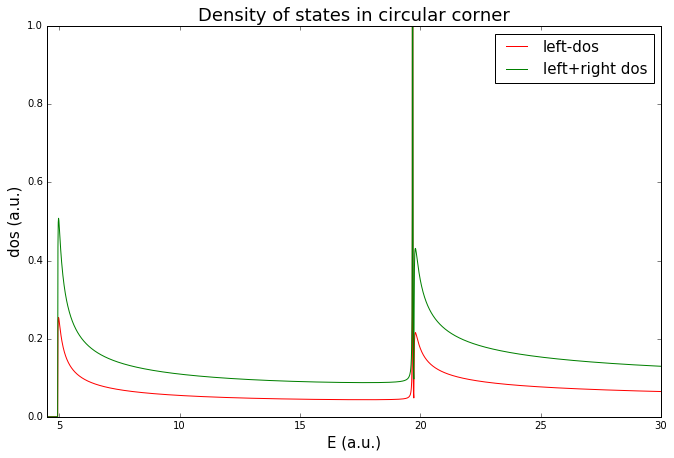

In [15]:
dos_range = 1.0 # range of dos plotted
plt.figure(figsize = (11, 7))
plt.axis([en_start, en_end, 0.0, dos_range])
plt.xlabel('E (a.u.)', fontsize = 15)
plt.ylabel('dos (a.u.)', fontsize = 15)
plt.title('Density of states in circular corner', fontsize = 18)
plt.plot(elist, left_dos,'red', label='left-dos') 
plt.plot(elist, dos, 'green', label='left+right dos')
plt.legend(loc='best', fontsize=15)

We see that $n_\mathrm{I,L}(E)$ is exactly $\frac{1}{2}$ of $n_\mathrm{I}(E)$: this is because in this case $n_\mathrm{I,R}=n_\mathrm{I,L}$, by symmetry. What is satisfying is the way that this works out, because we are calculating $n_\mathrm{I,L}$ and $n_\mathrm{I}$ by different expresssions. We must remember, however, that the left and right densities of states, arising as they do from travelling waves, do not include bound states which appear in $n_\mathrm{I}$ when $E$ is evaluated just above the real axis (as in notebook 2).  
The left and right densities of states are important for calculating the electronic structure in non-equilibrium situations, for example when there is a bias voltage across the nanostructure (that is, the voltage in the right-hand straight waveguide is different from that in the left-hand waveguide); this has been used by [Ishida](http://journals.aps.org/prb/abstract/10.1103/PhysRevB.75.205419) (H. Ishida, Phys. Rev. B **75** 205419 (2007)) in calculations of the conductance of Ag and Au monatomic wires.